# Dimensionality reduction of image quality metrics (IQMs)

We want to perform dimensionality reduction on the 62 IQMs not only to reduce the feature space, but also to try extracting interpretable latent variables, so we could get a better grasp on what features IQMs capture and which IQMs are most important. This dimensionality reduction is particularly motivated by the fact that many of these metrics are knowingly highly correlated. We can verify it this claim ourselves

This notebook gives an example of the type of analysis that can be ran on the IQMs automatically computed by [MRIQC](https://mriqc.readthedocs.io/en/stable/). Specifically, this analysis presented here consiste in applying different methods of dimensionality reduction on IQMs.

Before we start, let's set up a minimal framework (numpy, matplotlib, pandas, etc.)

In [2]:
#reload automatically external packages so that modifications are taken into account
%load_ext autoreload 
%autoreload 2
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
# mpl.rcParams['font.family'] = "Libre Franklin"

import matplotlib.pyplot as plt

## Load data

We first load the ABIDE dataset, one of the default datasets distributed with MRIQC-learn. The data comes with the already computed IQMs and quality grades manually assigned by raters.

As in the Visualization notebook, we will first *harmonize* the metrics using the `SiteRobustScaler` filter of MRIQC-learn.

In [7]:
import sys
sys.path.append('/mnt/sda1/Repos/mriqc/mriqc-learn/mriqc-learn')
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
# df = pd.read_excel('/home/jaimebarranco/Desktop/MRI-QC/scores.xlsx', sheet_name='brainmask_avg_data')

# Separate features (X) and target (y)
X = df_merged.drop(columns=['rating', 'bids_name'])
y = df_merged['rating']
features = X.columns.tolist()

# Train/test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

train_x = train_x.drop(columns=[
    "size_x",
    "size_y",
    "size_z",
    "spacing_x",
    "spacing_y",
    "spacing_z",
    "summary_bg_p05", # all zeros
])
numeric_columns = train_x.columns.tolist()

ratings = np.array(["Exclude"] * len(train_x))
ratings[train_y.values < 1] = "Exclude"
ratings[train_y.values >= 1] = "Accept"

Debugging : If running the previous cells indicates `ModuleNotFoundError: No module named 'mriqc_learn'`. You need to go into the mriqc-learn repository, run `pip install -e .[all]` to install the package in editable mode and all the dependencies, restart the kernel and the cell should run now.

Let's print out a pretty view of the data table:

In [4]:
train_x

,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
44,0.458780,3.026696,0.530533,31479.275776,3.534280,3.36246,3.81101,3.42937,0.196113,0.367899,...,1004.958362,1000.102938,193978.000000,927.668848,1098.723008,52.734446,0.154101,0.433499,0.495507,0.503351
96,0.858362,0.752773,0.620926,13665.314052,3.849363,3.79601,4.02355,3.72853,0.241568,0.340757,...,978.672834,984.437393,715138.101056,839.288763,1099.416404,78.852201,0.224228,0.470063,0.507912,0.491630
129,0.872209,0.812322,0.608945,9673.837841,3.884610,3.53374,4.09389,4.02620,0.246818,0.354548,...,962.583833,968.007884,661835.694143,795.083191,1113.189094,96.669257,0.240878,0.479147,0.486519,0.428411
83,0.962402,0.900891,0.552676,15244.334361,3.560010,3.43493,3.80826,3.43684,0.250540,0.368282,...,958.515438,962.947897,535077.010529,803.737352,1099.815478,89.381447,0.222608,0.514994,0.535311,0.483405
54,0.462511,3.000697,0.602119,20080.875654,3.665620,3.44724,3.99917,3.55045,0.220363,0.367322,...,1005.052567,1000.096839,204126.000000,921.771042,1104.455893,56.212025,0.166549,0.438769,0.506024,0.506790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.914764,0.856121,0.605692,15856.621302,3.573560,3.40568,3.79624,3.51876,0.253957,0.361365,...,980.631181,984.297031,640357.606755,838.868214,1109.566697,81.933200,0.223798,0.515264,0.546642,0.491809
67,0.448091,3.094118,0.543796,28555.917519,3.500230,3.33013,3.76717,3.40339,0.215502,0.381438,...,1003.556587,1000.062877,175130.000000,930.591960,1088.987413,48.578024,0.170574,0.444431,0.521019,0.533905
117,0.895894,0.900136,0.530791,14186.568578,3.633063,3.53874,3.88858,3.47187,0.255047,0.356547,...,933.429321,943.748302,483990.744433,769.839655,1071.240890,92.563537,0.213632,0.497932,0.515718,0.481202
47,0.445324,3.058757,0.554685,30115.786983,3.620553,3.49549,3.85356,3.51261,0.221696,0.372123,...,1004.453785,1000.055751,230176.000000,936.090105,1088.865944,46.824035,0.172665,0.427342,0.510288,0.613959


### PCA

If we look at the correlation plot of the Visualization notebook, we will identify blocks of IQMs where the correlation coefficients almost reaches 1 or -1.

Principal component analysis (PCA) could apply as a dimensionality reduction method, as it transforms a set of correlated variables into a smaller set of uncorrelated variables, while retaining as much of the variation in the original dataset as possible. Let's thus run PCA.

In [5]:
from scipy import stats
from sklearn.decomposition import PCA

In [6]:
# PCA
pca = PCA(n_components=None)
pca = pca.fit(train_x[numeric_columns]) #n_samples x n_features

One tricky point in running PCA is to choose how many components to keep. Let's visualize the cumulative variance explained to inform our decision.

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22'),
 Text(22, 0, '23'),
 Text(23, 0, '24'),
 Text(24, 0, '25'),
 Text(25, 0, '26'),
 Text(26, 0, '27'),
 Text(27, 0, '28'),
 Text(28, 0, '29'),
 Text(29, 0, '30'),
 Text(30, 0, '31'),
 Text(31, 0, '32'),
 Text(32, 0, '33'),
 Text(33, 0, '34'),
 Text(34, 0, '35'),
 Text(35, 0, '36'),
 Text(36, 0, '37'),
 Text(37, 0, '38'),
 Text(38, 0, '39'),
 Text(39, 0, '40'),
 Text(40, 0, '41'),
 Text(41, 0, '42'),
 Text(42, 0, '43'),
 Text(43, 0, '44'),
 Text(44, 0, '45'),
 Text(45, 0, '46'),
 Text(46, 0, '47'),
 Text(47, 0, '48'),
 Text(48, 0, '49'),
 Text(49, 0, '50'),
 Text(50, 0, '51'),

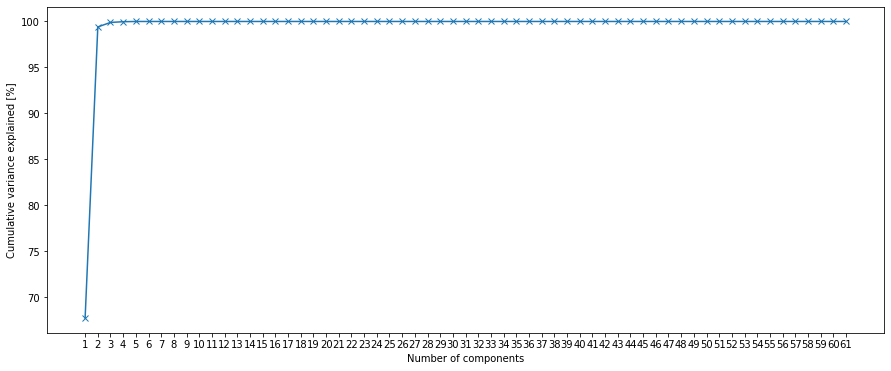

In [7]:
# Plot cumulative variance explained
fig = plt.figure(figsize=(15,6))
ax = plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100), "-x")
plt.ylabel("Cumulative variance explained [%]")
plt.xlabel("Number of components")
xticks = np.arange(0, pca.explained_variance_ratio_.size, dtype=int)
plt.xticks(xticks)
plt.gca().set_xticklabels(xticks + 1)

Here we decide to choose 15 components so to reach 90% of variance explained. This decision is a bit arbitrary, I encourage you to play with the number of components to see how it modifies your results.

In [8]:
n_components = 2

To be able to interpret components found by PCA, we would like PCA components to present just a few IQMs that stand out through high weights. Then through the definition of those IQMs, we could try to assign what feature does this component capture in the image. Let's plot the weights for each component in the search of such a scenario.

/tmp/ipykernel_194921/3274433082.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[k].set_xticklabels(numeric_columns, rotation=90)


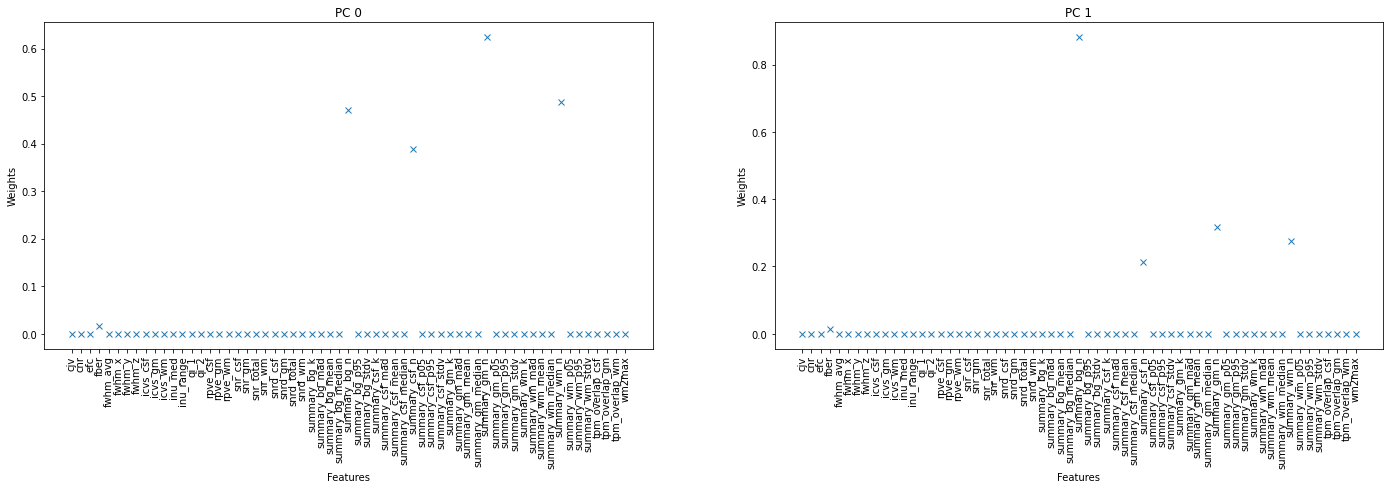

In [17]:
# Plot PCA components' weights
basis = pca.components_[:n_components,:]
fig, axs = plt.subplots(1,n_components,sharex=False,sharey=False,figsize=(24, 6))
for k in range(basis.shape[0]):
    axs[k].plot(abs(basis[k,:]),'x')
    axs[k].set_title('PC {}'.format(k))
    axs[k].set_xticklabels(numeric_columns, rotation=90)
    axs[k].set_xticks(range(len(numeric_columns)))
    axs[k].set_xlabel('Features')
    axs[k].set_ylabel('Weights')

Unfortunately, for most of the PC there aren't really IQMs that stand out from the crowd; mostly it is a continuous sea of points when I would really like to observe outliers. But actually, if we are looking for interpretability, a more suitable dimensionality reduction method is factor analysis (FA), as it is tailored to finding interpretable latent variables. Let's thus try to perform FA on our data.

In [ ]:
from mriqc_learn.viz import metrics

iqm_reduced = PCA(n_components=n_components).fit_transform(
  scaled_x[numeric_columns]
)
components = pd.DataFrame(iqm_reduced, columns=[f"PC{i}" for i in range(1, n_components + 1)])
components["site"] = scaled_x["site"].values
metrics.plot_batches(components);

In [ ]:
components

### Factor analysis

In [18]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.pipeline import Pipeline
import seaborn as sns

Factor analysis, as any other statistical method, requires a certain number of assumptions to be verified, before the method can trusthworthily be applied. The two following tests are standard tests to verify that the data are respecting those assumptions (cf https://www.datacamp.com/community/tutorials/introduction-factor-analysis))

In [19]:
#Check that correlation matrix is not identity = sphericity check
chi_square_value,p_value=calculate_bartlett_sphericity(train_x[numeric_columns])
if p_value > 0.5:
    raise ValueError('There should be correlations in your data') 
    
#Check suitability of data for FA
kmo_all,kmo_model=calculate_kmo(train_x[numeric_columns])
if kmo_model<0.6:
    raise ValueError('Data not suitable for FA')

/home/jaimebarranco/miniconda3/envs/a-eye/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


The data passed both tests, we can therefore run FA.

In [20]:
fa = FactorAnalyzer().fit(train_x[numeric_columns])

As for PCA, a tricky choice is the number of factors to extract. There are several methods assisting that choice. 
The first method, so called scree plot, is to plot the eigenvalues associated to the number of factors and keep the value at the elbow. The second method is to keep the number of factors for which the eigenvalue is bigger than 1. The third method is called parallel analysis. The idea is to generate a random normally distributed data, perform FA on this synthetic dataset and keep the number of factors for which the eigenvalue curve from the original and the synthetic data intersect. It is a good idea to try the several methods to observe if they point toward the same number of factors. We will thus plot the different strategies. 

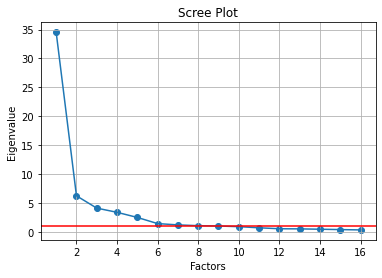

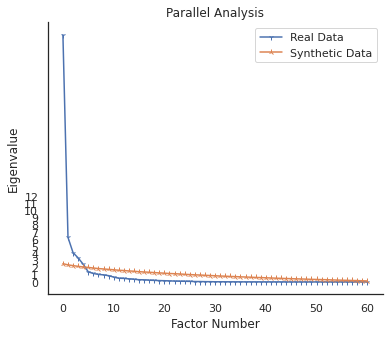

Parallel analysis suggests to keep 5 factors


In [21]:
# Helper functions to decide run parallel analysis (Thanks to Mikkel Schoettner for sharing his code)

def parallel_analysis(data, k=20, method="minres", return_ev=False):
    import numpy as np
    import matplotlib.pyplot as plt
    from factor_analyzer import FactorAnalyzer

    # get shape of the data
    n, m = data.shape

    # initialize FactorAnalyzer
    fa = FactorAnalyzer(n_factors=m, rotation="varimax", method=method)

    # list to store eigenvalues
    eig = np.ones((k, m))

    # loop for k iterations
    for i in range(k):
        # print("Iteration", i+1)
        # generate random data
        rnd_data = np.random.normal(size=(n, m))
        # run factor analysis
        fa.fit(rnd_data)
        # extract eigenvalues
        ev, v = fa.get_eigenvalues()
        eig[i] = eig[i] * ev

    # average eigenvalues for random data
    avg_eig = np.mean(eig, axis=0)

    # run factor analysis on data
    fa.fit(data)
    ev, v = fa.get_eigenvalues()

    # determine suggested no. of factors
    suggestedFactors = sum((ev - avg_eig) > 0)
    if return_ev:
        return suggestedFactors, ev, avg_eig
    else:
        return suggestedFactors
    
    
def plot_pa_single(ev, avg_eig, save_plot = False):
    # plot eigenvalues of actual and random data
    sns.set_theme(style='white')
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    ax.plot(range(len(ev)), ev, marker="1", label="Real Data")
    ax.plot(range(len(ev)), avg_eig, marker="2", label="Synthetic Data")
    ax.set_xticks(range(0, len(ev), 10))
    ax.set_yticks(range(0, 13, 1))
    ax.set_xlabel('Factor Number')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Parallel Analysis')
    ax.legend()
    sns.despine()
    if save_plot == True:
        fig.savefig(outpath_efa+"parallel_analysis.svg")
    plt.show()
    return

# Scree Plot
ev, v = fa.get_eigenvalues()
plt.scatter(range(1,train_x[numeric_columns].shape[1]+1-45),ev[:-45])
plt.plot(range(1,train_x[numeric_columns].shape[1]+1-45),ev[:-45])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
#plot the line corresponding the an eigenvalue of 1
plt.axhline(y=1, color='r')
plt.grid()
plt.show()

#Parallel analysis
suggestedFactors, ev22, avg_ev = parallel_analysis(train_x[numeric_columns], k=20, method="ml", return_ev=True)
plot_pa_single(ev, avg_ev)
print('Parallel analysis suggests to keep {} factors'.format(suggestedFactors))

Evidences from the different methods converge that 6 is a good number of factors to keep

In [22]:
n_factors = 5

Now that we have determined the number of factors, we can run FA and tell it how many factors to extract. Furthermore, we apply rotation to the factors, because this rotation convert factors into uncorrelated factors improving in the process interpretabiity.

In [46]:
fa = FactorAnalyzer(rotation="varimax", n_factors=n_factors)
fa = fa.fit(train_x[numeric_columns])

By looking at the loadings of each factor, comes now the hard task of assigning interpretation on each factor. The heatmap is a good visualisation tool to help grasp all factors in one glimpse.

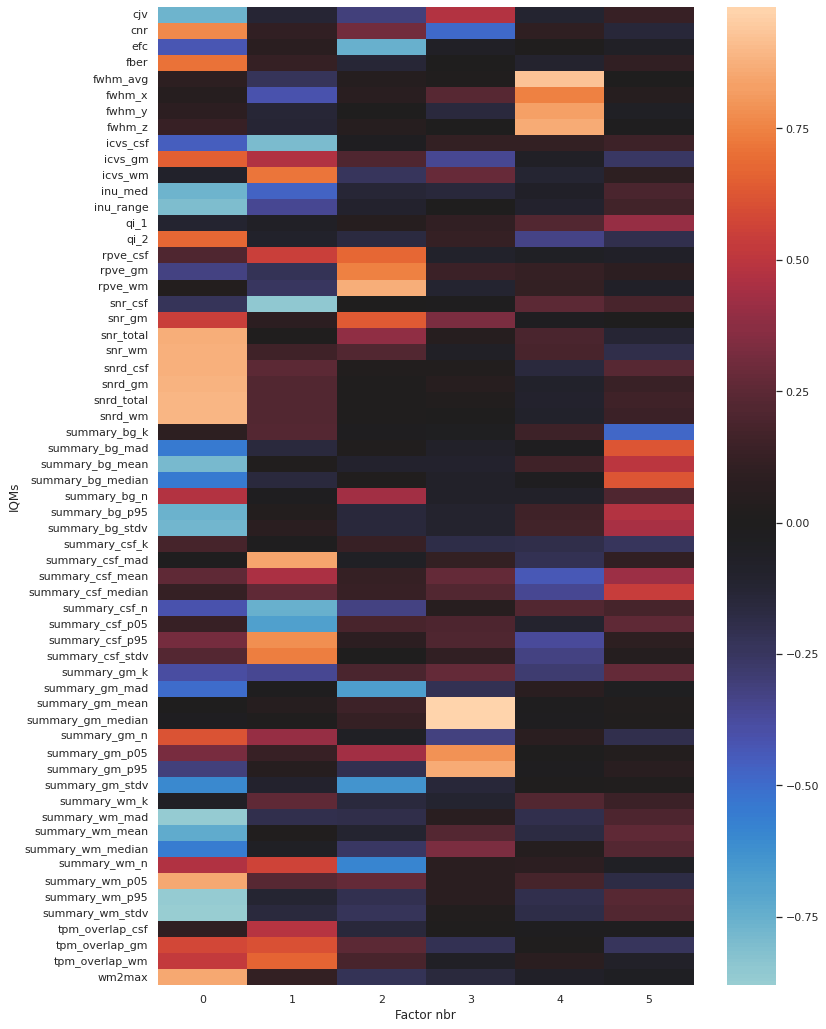

In [47]:
fig = plt.figure(figsize=(12,18))
ax = sns.heatmap(fa.loadings_, center=0)
ax.set_xlabel('Factor nbr')
ax.set_ylabel('IQMs')
ax.set_yticklabels(numeric_columns, rotation=0)
plt.show()

### Backward feature elimination

Another approach to dimensionality reduction would be instead of combining the different IQMs together, we could extract only the most important ones. This can be achieved via backward feature elimination.

The concept is that the model is first trained with all features, the performance is assessed using the target data to give a referencial performance. Then the model is retrained by droping one feature at a time and performance is assessed. The feature that affected the performance the least is eliminated. This process iterates until only the most important feature remains.

The inverse process exists, that is forward feature selection. However the latter is advised only when the number of variables under consideration is very large, even larger than the sample size. If it is not the case, backward feature elimination should be used, especially in case of collinearity as it considers the effects of all variables simultaneously. This means that backward elimination may force to keep all collinear feature while forward selection might select none of them. (cf https://quantifyinghealth.com/stepwise-selection/)

For implementing the method, we choose the Linear Discriminant Analysis (LDA) classifier with as target the manual ratings. The choice of LDA is arbitrary, you can try to play with other multi-class classifiers. Moreover, we choose the backward implementation, as we know our IQMs are collinear and we keep the 5 most important IQMs, which is also an arbitrary decision.

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [9]:
k_features = 5
clf = LinearDiscriminantAnalysis()
sfs = SFS(
    clf, 
    k_features=k_features, 
    forward=False, 
    verbose=0,
)
sfs = sfs.fit(train_x[numeric_columns], ratings)

kept_features = list(sfs.k_feature_names_)
print(f"The {k_features} most important IQMs are {', '.join(sfs.k_feature_names_)}.")

The 6 most important IQMs are snr_csf, snrd_csf, summary_bg_mad, summary_bg_mean, summary_csf_p95, summary_wm_median.


It is also possible to extract the order in which features have been eliminated. Here is my implementation.

In [10]:
feat_names = list(sfs.k_feature_names_)

#feature eliminated in order
eliminated_feat = []
for i in reversed(range(k_features, train_x[numeric_columns].shape[1]-1)):
    feat0 = sfs.subsets_[i]["feature_names"]
    feat1 = sfs.subsets_[i+1]["feature_names"]
    el_feat = list(set(feat1) - set(feat0))
    eliminated_feat.append(el_feat[0])

print(
    "Here is the order in which the features have been eliminated "
    "(1st in the list is the 1st feature to have been eliminated):\n"
    f"{', '.join(eliminated_feat)}"
)

Here is the order in which the features have been eliminated (1st in the list is the 1st feature to have been eliminated):
tpm_overlap_gm, summary_wm_k, summary_bg_median, snrd_total, fwhm_x, snr_wm, icvs_wm, summary_csf_mean, fwhm_y, inu_range, summary_wm_p95, summary_gm_stdv, summary_csf_median, summary_wm_p05, summary_bg_k, summary_gm_k, summary_csf_p05, summary_gm_p95, summary_wm_mad, summary_gm_mad, summary_csf_n, tpm_overlap_wm, tpm_overlap_csf, wm2max, summary_gm_mean, qi_2, summary_gm_p05, snr_total, rpve_gm, icvs_gm, snrd_gm, fber, summary_wm_mean, summary_csf_stdv, summary_bg_p95, fwhm_z, fwhm_avg, efc, cnr, summary_wm_stdv, cjv, summary_bg_n, snr_gm, rpve_csf, rpve_wm, summary_gm_median, summary_wm_n, summary_gm_n, icvs_csf, inu_med, snrd_wm, summary_csf_k, summary_bg_stdv, summary_csf_mad
